## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [3]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

'wget' is not recognized as an internal or external command,
operable program or batch file.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [5]:
#1 Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

import pandas as pd
import numpy as np

np.random.seed(1235)

usr_path = "data_000637.txt"

usr_data=pd.read_csv(usr_path)

print(usr_data)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns]


In [7]:
#2 Find out the number of BX in a ORBIT (the value 'x').

x = usr_data['BX_COUNTER'].max()

print('X: ', x)

X:  3563


In [8]:
#3 Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

usr_data['time_ns'] = (usr_data['ORBIT_CNT']*x+usr_data['BX_COUNTER'])*25

usr_data_ac = usr_data['time_ns'].max() - usr_data['time_ns'].min()

print('usr_data took:',usr_data_ac,'ns')

usr_data took: 980141175 ns


In [9]:
#4 Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

usr_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,1,0,123,3869200167,2374,26,344649004934875
1,1,0,124,3869200167,2374,27,344649004934875
2,1,0,63,3869200167,2553,28,344649004939350
3,1,0,64,3869200167,2558,19,344649004939475
4,1,0,64,3869200167,2760,25,344649004944525
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344649985075875
1310716,1,1,4,3869211171,763,11,344649985075900
1310717,1,0,64,3869211171,764,0,344649985075925
1310718,1,0,139,3869211171,769,0,344649985076050


In [10]:
#5 Replace the values (all 1) of the HEAD column randomly with 0 or 1.

x = len(usr_data['HEAD'])

rand_head = np.random.choice([0,1],size=x)

usr_data['HEAD'] = rand_head

usr_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,1,0,123,3869200167,2374,26,344649004934875
1,0,0,124,3869200167,2374,27,344649004934875
2,0,0,63,3869200167,2553,28,344649004939350
3,1,0,64,3869200167,2558,19,344649004939475
4,1,0,64,3869200167,2760,25,344649004944525
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344649985075875
1310716,1,1,4,3869211171,763,11,344649985075900
1310717,1,0,64,3869211171,764,0,344649985075925
1310718,1,0,139,3869211171,769,0,344649985076050


In [11]:
#6 Create a new DataFrame that contains only the rows with HEAD=1.

new_usr_data = usr_data[usr_data['HEAD'] == 1]
new_usr_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
0,1,0,123,3869200167,2374,26,344649004934875
3,1,0,64,3869200167,2558,19,344649004939475
4,1,0,64,3869200167,2760,25,344649004944525
5,1,0,63,3869200167,2762,4,344649004944575
6,1,0,61,3869200167,2772,14,344649004944825
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,344649985075875
1310716,1,1,4,3869211171,763,11,344649985075900
1310717,1,0,64,3869211171,764,0,344649985075925
1310718,1,0,139,3869211171,769,0,344649985076050


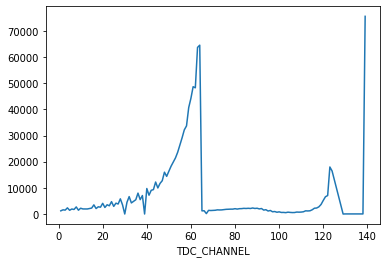

In [12]:
#7 Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

%matplotlib inline

FPGA_0 = usr_data[usr_data['FPGA'] == 0]

gp = FPGA_0.groupby('TDC_CHANNEL').count()

gp['HEAD'].plot()

In [13]:
#8 Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

i = usr_data.groupby('TDC_CHANNEL').sum()

i = i.sort_values(by='TDC_MEAS', ascending=False)

i.head()

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time_ns
TDC_CHANNEL,,,,,,
64,33115,1439.0,2.554450e+14,117767051.0,962195.0,2.275376e+19
63,32523,918.0,2.501132e+14,115482430.0,938192.0,2.227884e+19
62,24588,1074.0,1.909415e+14,87956183.0,719092.0,1.700811e+19
61,24801,780.0,1.914445e+14,88234674.0,719044.0,1.705291e+19
60,22863,1473.0,1.769620e+14,81237774.0,662400.0,1.576289e+19


In [14]:
#9 Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

unique = usr_data['ORBIT_CNT'].unique().shape[0]

print("Unique: ", unique)

tdc_139 = usr_data[usr_data['TDC_CHANNEL'] == 139]

unique = tdc_139['ORBIT_CNT'].unique().shape[0]

print("Unique TDC_CHANNEL = 139: ", unique)

Unique:  11001
Unique TDC_CHANNEL = 139:  10976
